# Expected Yards

What is the expected number of yards gained for a given offensive play against 2-high safety coverage (Cover 2, Cover 4, Man Cover 2)

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss
from lightgbm import LGBMRegressor

import pymc as pm
import pymc_bart as pmb
import arviz as az

pd.set_option('display.max_columns', None)

In [46]:
football_data = pd.read_csv('2026_FAB_play_by_play.csv').copy()

/var/folders/6l/fh4ck8px62x4x7vp3j9kjr6h0000gn/T/ipykernel_7336/4148201887.py:1: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  football_data = pd.read_csv('2026_FAB_play_by_play.csv').copy()


In [47]:
## the coveragetype on run plays is N/A --> only when the qb scrambles does a rush have a not N/A coveragetype
football_data['CoverageType'] = football_data['CoverageType'].fillna('Run Defense')
## the only play where DL/LB/DB are null is a throwaway pass from Love --> can be discarded
football_data = football_data[~football_data['DL'].isna()].reset_index(drop=True).copy()
## null dropback/droptype always guarantee it is a run play, but a run play does not guarantee a missing dropback/droptype
football_data['Dropback'] = football_data['Dropback'].fillna(0) ## we can fill in with 0
football_data['DropType'] = football_data['DropType'].fillna('No Dropback') ## we just denote this as there being no dropback on the play
## null attempt always guarantee it is a run play, but a run play does not guarantee a missing attempt
football_data['Attempt'] = football_data['Attempt'].fillna(0) ## we can fill in with 0
## null completion always guarantee it is a run play
football_data['Completion'] = football_data['Completion'].fillna(0) ## we can fill in with 0
## null sacked always guarantee it is a run play
football_data['Sacked'] = football_data['Sacked'].fillna(0) ## we can fill in with 0
## targeted player is null when there is a rush or a throw out of bounds or throw to no one
football_data['TargetedPlayer'] = football_data['TargetedPlayer'].fillna('No Target') ## we just denote this as there being no dropback on the play
## the number of players on each side e.g., LWR, LSWR, ..., RWR, RSWR are null on fake special teams --> we'll just get rid of these plays
football_data = football_data[~football_data['LWR'].isna()].reset_index(drop=True).copy()
## null EPA is a kyren williams TD that wasn't given an EPA --> we just have to throw it out
football_data = football_data[~football_data['EPA'].isna()].reset_index(drop=True).copy()
## null L1/L2/L3/L4/R4/R3/R2/R1 happen when the receivers at that spot either block or there aren't any receivers at that spot --> basically no run route
## we can just fill it in as denoting it as no route ran --> block/no route
football_data[['L1', 'L2', 'L3', 'L4', 'R1', 'R2', 'R3', 'R4']] = football_data[['L1', 'L2', 'L3', 'L4', 'R1', 'R2', 'R3', 'R4']].fillna('No Route')
## these kind of plays are weird (e.g., mis-snap)
football_data = football_data[football_data['DropType'] != 'Other'].reset_index(drop=True).copy()
## got rid of misc plays that wouldn't say anything informative about offense vs defense
football_data = football_data[~football_data['CoverageType'].isin(['Spike', 'Other'])].reset_index(drop=True).copy()

In [48]:
def get_drop_depth(x):
    if '0/1 Step' in x:
        return 1
    elif '3 Step' in x:
        return 3
    elif '5 Step' in x:
        return 5
    elif '7 Step' in x:
        return 7
    else: ## screens, RPOs, and rollouts that don't have a standard depth
        return 0
    
def get_play_concept(x):
    if any(i in x for i in ['Designed Rollout Right', 'Designed Rollout Left']): 
        return 'Rollout'
    if any(i in x for i in ['RPO', 'RPO Move']): 
        return 'RPO'
    if any(i in x for i in ['Flea Flicker', 'Double Reverse Pass', 'WR Reverse Pass', 'RB/WR Pass']): 
        return 'Trick'
    if 'Basic Screen' in x:
        return 'Screen'
    return 'Standard'

def clean_coverage_type(x):
    coverage = x['CoverageType']
    num_safeties = x['Safeties']

    ## screen is not a kind of coverage type but a reaction to the play
    if coverage == 'Screen':
        if num_safeties == 2:
            return 'Cover 2'
        elif num_safeties == 1:
            return 'Cover 3'
        elif num_safeties == 0:
            return 'Blitz'
        else:
            return 'Prevent'
    
    if coverage in ['Goal Line', 'Red 2']:
        return 'Goal Line'
    
    if coverage == 'Prevent':
        return 'Prevent'
    
    return coverage

def distance_to_go(x):
    start_yard = x['StartYard']
    field_side = x['FieldSide']

    if field_side == 'Own':
        return 100 - start_yard
    else:
        return start_yard

football_data['Personnel'] = football_data['RB'].astype(str) + football_data['TE'].astype(str)
football_data['2MinWarning'] = ((football_data['QTR'] == 2) & (football_data['TimeLeftQTR'] <= 120)).astype(int)
football_data['BoxCount'] = (football_data['DL'] + football_data['LB']).astype(int)
football_data['Dropback'] = football_data['Dropback'].astype(int)
football_data['DistanceToGo'] = football_data.apply(distance_to_go, axis=1)
football_data['DropDepth'] = football_data['DropType'].apply(get_drop_depth)
football_data['PlayConcept'] = football_data['DropType'].apply(get_play_concept)
football_data['CoverageType'] = football_data.apply(clean_coverage_type, axis=1)

## Modeling

### Preprocessing

In [49]:
game_context = ['Down', 'ToGo', 'DistanceToGo', 'TimeLeftQTR', 'OffLeadBefore', 'QTR', '2MinWarning']
defensive_context = ['Safeties', 'BoxCount', 'CoverageType']
play_design = ['Dropback', 'DropDepth', 'PlayConcept', 'Personnel', 'ReceiverAlignment', 'L1', 'L2', 'L3', 'L4', 'R4', 'R3', 'R2', 'R1']
target = 'YardsOnPlay'

X = football_data[game_context + defensive_context + play_design + ['DefTeam']]
y = football_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=football_data['CoverageType'], random_state=42)

## adding the talent level of each team without explicitly incorporating each team
train_df = X_train.copy()
train_df[target] = y_train
stats_df = train_df.groupby(['DefTeam', 'Dropback'])[target].mean().unstack()
stats_df.columns = ['DefAvgRun', 'DefAvgPass']
X_train = X_train.join(stats_df, on='DefTeam')
X_test = X_test.join(stats_df, on='DefTeam')

nominal_features = ['CoverageType', 'PlayConcept', 'Personnel', 'ReceiverAlignment', 'L1', 'L2', 'L3', 'L4', 'R4', 'R3', 'R2', 'R1',]
ordinal_features = ['Down', 'QTR', 'DropDepth', 'Safeties', 'BoxCount',]
binary_features = ['Dropback', '2MinWarning']
numeric_features = ['ToGo', 'DistanceToGo', 'TimeLeftQTR', 'OffLeadBefore', 'DefAvgRun', 'DefAvgPass']
passthrough_features = ordinal_features + binary_features + numeric_features

global_avg_run = train_df[train_df['Dropback']==0][target].mean()
global_avg_pass = train_df[train_df['Dropback']==1][target].mean()
X_test['DefAvgRun'] = X_test['DefAvgRun'].fillna(global_avg_run)
X_test['DefAvgPass'] = X_test['DefAvgPass'].fillna(global_avg_pass)

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features), 
                                               ('num', 'passthrough', passthrough_features)], 
                                               verbose_feature_names_out=False)
preprocessor.set_output(transform="pandas")

## just wanted it for the talent data
X_train = X_train.drop(columns=['DefTeam'])
X_test = X_test.drop(columns=['DefTeam'])

### Quantile Modeling

In [50]:
quantiles = [0.025, 0.1, 0.5, 0.9, 0.975]

cv_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for q in quantiles:
    fold_scores = {'pinball': [], 'rmse': [], 'mae': [], 'actual_coverage': []}
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, X_train['CoverageType'])):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        cv_pipeline = Pipeline([('preprocessor', preprocessor), 
                                ('regressor', LGBMRegressor(objective='quantile', alpha=q, random_state=42, n_jobs=-1, verbose=-1))
                                ])
        cv_pipeline.fit(X_fold_train, y_fold_train)
        y_fold_pred = cv_pipeline.predict(X_fold_val)
        fold_scores['pinball'].append(mean_pinball_loss(y_fold_val, y_fold_pred, alpha=q))
        fold_scores['rmse'].append(np.sqrt(mean_squared_error(y_fold_val, y_fold_pred)))
        fold_scores['mae'].append(mean_absolute_error(y_fold_val, y_fold_pred))
        fold_scores['actual_coverage'].append((y_fold_val < y_fold_pred).mean())

    cv_results.append({'Quantile': q, 
                       'avg pinball': np.mean(fold_scores['pinball']), 
                       'avg rmse': np.mean(fold_scores['rmse']),
                       'avg mae': np.mean(fold_scores['mae']),
                       'avg coverage': np.mean(fold_scores['actual_coverage'])
                       })

In [51]:
models = {}
for q in quantiles:
    pipeline = Pipeline([('preprocessor', preprocessor), 
                            ('regressor', LGBMRegressor(objective='quantile', alpha=q, random_state=42, n_jobs=-1)),
                            ])
    pipeline.fit(X_train, y_train)
    models[f'q{int(q*100)}'] = pipeline

In [52]:
metrics_list = []
for name, pipeline in models.items():
    q_val = int(name[1:]) / 100.0
    y_pred = pipeline.predict(X_test)
    metrics_list.append({'Model': name, 
                         'Target Quantile': q_val, 
                         'Pinball Loss': mean_pinball_loss(y_test, y_pred, alpha=q_val), 
                         'Actual Coverage': (y_test < y_pred).mean(), 
                         'MAE': mean_absolute_error(y_test, y_pred), 
                         'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                         })

In [53]:
print(pd.DataFrame(metrics_list))

  Model  Target Quantile  Pinball Loss  Actual Coverage        MAE       RMSE
0    q2             0.02      0.343149         0.035376  10.278305  13.723347
1   q10             0.10      0.970598         0.099804   6.547563  10.542051
2   q50             0.50      2.660031         0.516785   5.320061   8.787201
3   q90             0.90      1.670570         0.886798   9.975305  12.435303
4   q97             0.97      0.818507         0.964925  18.090423  20.471860


In [58]:
X_full = football_data[game_context + defensive_context + play_design + ['DefTeam']].copy()
y_full = football_data[target].copy()
full_df = X_full.copy()
full_df[target] = y_full
stats_df_full = full_df.groupby(['DefTeam', 'Dropback'])[target].mean().unstack()
stats_df_full.columns = ['DefAvgRun', 'DefAvgPass']
X_full = X_full.join(stats_df_full, on='DefTeam')
X_full['DefAvgRun'] = X_full['DefAvgRun'].fillna(full_df[full_df['Dropback']==0][target].mean())
X_full['DefAvgPass'] = X_full['DefAvgPass'].fillna(full_df[full_df['Dropback']==1][target].mean())
X_full = X_full.drop(columns=['DefTeam'])

In [59]:
models = {}
for q in quantiles:
    pipeline = Pipeline([('preprocessor', preprocessor), 
                            ('regressor', LGBMRegressor(objective='quantile', alpha=q, random_state=42, n_jobs=-1)),
                            ])
    pipeline.fit(X_full, y_full)
    models[f'q{int(q*100)}'] = pipeline
    joblib.dump(pipeline, f'quantile_model/lgbm_quantile_q{int(q*100)}.pkl')

In [60]:
X_full

,Down,ToGo,DistanceToGo,TimeLeftQTR,OffLeadBefore,QTR,2MinWarning,Safeties,BoxCount,CoverageType,Dropback,DropDepth,PlayConcept,Personnel,ReceiverAlignment,L1,L2,L3,L4,R4,R3,R2,R1,DefAvgRun,DefAvgPass
0,1,10,65,894,0,1,0,2,7,Cover 2,1,1,Standard,21,Spread,Hook,Cross,Out,No Route,No Route,No Route,Shallow,Cross,4.101408,6.755869
1,1,10,54,850,0,1,0,1,7,Run Defense,0,0,Standard,12,Slot Left,No Route,No Route,No Route,No Route,No Route,No Route,No Route,No Route,4.101408,6.755869
2,2,6,50,806,0,1,0,1,7,Cover 6,1,5,Standard,12,Twin Right,Cross,No Route,No Route,No Route,No Route,No Route,Post,Corner,4.101408,6.755869
3,1,10,60,794,-7,1,0,1,6,Cover 1,1,3,Standard,12,Balanced,Cross,No Route,No Route,No Route,No Route,No Route,Flat,Corner,4.262911,6.126806
4,2,10,60,789,-7,1,0,1,7,Run Defense,0,0,Standard,21,Trips Left,No Route,No Route,Screen,No Route,No Route,No Route,No Route,No Route,4.262911,6.126806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33210,1,10,45,120,2,4,0,1,6,Run Defense,0,0,Standard,11,Balanced,No Route,No Route,No Route,No Route,No Route,No Route,No Route,No Route,4.179601,6.588235
33211,2,8,43,116,2,4,0,1,7,Run Defense,0,0,Standard,11,Balanced,No Route,No Route,No Route,No Route,No Route,No Route,No Route,No Route,4.179601,6.588235
33212,3,6,41,71,2,4,0,1,7,Run Defense,0,0,Standard,12,Balanced,No Route,No Route,No Route,No Route,No Route,No Route,No Route,No Route,4.179601,6.588235
33213,1,10,97,18,-2,4,0,3,5,Prevent,1,3,Standard,11,Trips Right,Corner,No Route,No Route,No Route,No Route,Out,Corner,Out,4.101408,6.755869


In [ ]:
sample_play = 

### BART Modeling

In [22]:
X_train_processed = preprocessor.fit_transform(X_train)
X_bart = X_train_processed.iloc[:2000].values ## the MCMC sampling is gonna take awhile so we'll downsample 
y_bart = y_train.iloc[:2000].values

In [29]:
with pm.Model() as football_bart:
    X_data = pm.Data("X_data", X_bart)
    Y_data = pm.Data("Y_data", y_bart)

    mu = pmb.BART('mu', X=X_data, Y=Y_data, m=50) ## the expected # of yards
    y_std_proxy = np.log(np.abs(y_bart - np.mean(y_bart)) + 1e-6) ## the volatility of the expected yards, the 1e-6 is so we don't get ln(0)    
    sigma_log = pmb.BART('sigma_log', X=X_data, Y=y_std_proxy, m=50)
    sigma = pm.Deterministic('sigma', pm.math.exp(sigma_log))

    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y_data) ## modeling the likelihood as a N(mu, sigma) distrib

    idata = pm.sample(draws=2000, tune=2000, chains=4, pgbart={'sample_kwargs': {'mode': 'MLX'}}, random_seed=42) ## the MCMC sampling over the likelihood x priors

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>PGBART: [sigma_log]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 242 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [33]:
summary = az.summary(idata, var_names=["mu", "sigma", "sigma_log"])
summary.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],3.572,0.711,2.276,4.975,0.023,0.012,995.0,1519.0,1.0
mu[1],3.470,0.920,1.694,5.167,0.029,0.015,1004.0,1941.0,1.0
mu[2],3.434,0.902,1.769,5.120,0.030,0.018,928.0,1533.0,1.0
mu[3],6.242,0.959,4.481,8.005,0.030,0.015,1020.0,2066.0,1.0
mu[4],5.731,1.023,3.917,7.680,0.033,0.018,979.0,1660.0,1.0


/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (2000), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n0'}>],
       [<Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n1'}>],
       [<Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n2'}>],
       [<Axes: title={'center': 'sigma\n3'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'sigma\n4'}>,
        <Axes: title={'center': 'sigma\n4'}>],
       [<Axes: title={'center': 'sigma\n5'}>,
        <Axes: title={'center': 'sigma\n5'}>],
       [<Axes: title={'center': 'sigma\n6'}>,
        <Axes: title={'center': 'sigma\n6'}>],
       [<Axes: title={'center': 'sigma\n7'}>,
        <Axes: title={'center': 'sigma\n7'}>],
       [<Axes: title={'center': 'sigma\n8'}>,
        <Axes: title={'center': 'sigma\n8'}>],
       [<Axes: title={'center': 'sigma\n9'}>,
        <Axes: title={'center': 'sigma\n9'}>],
       [<Axes: title={'center': 'sigma\n10'}>,
        <Axes: title={'

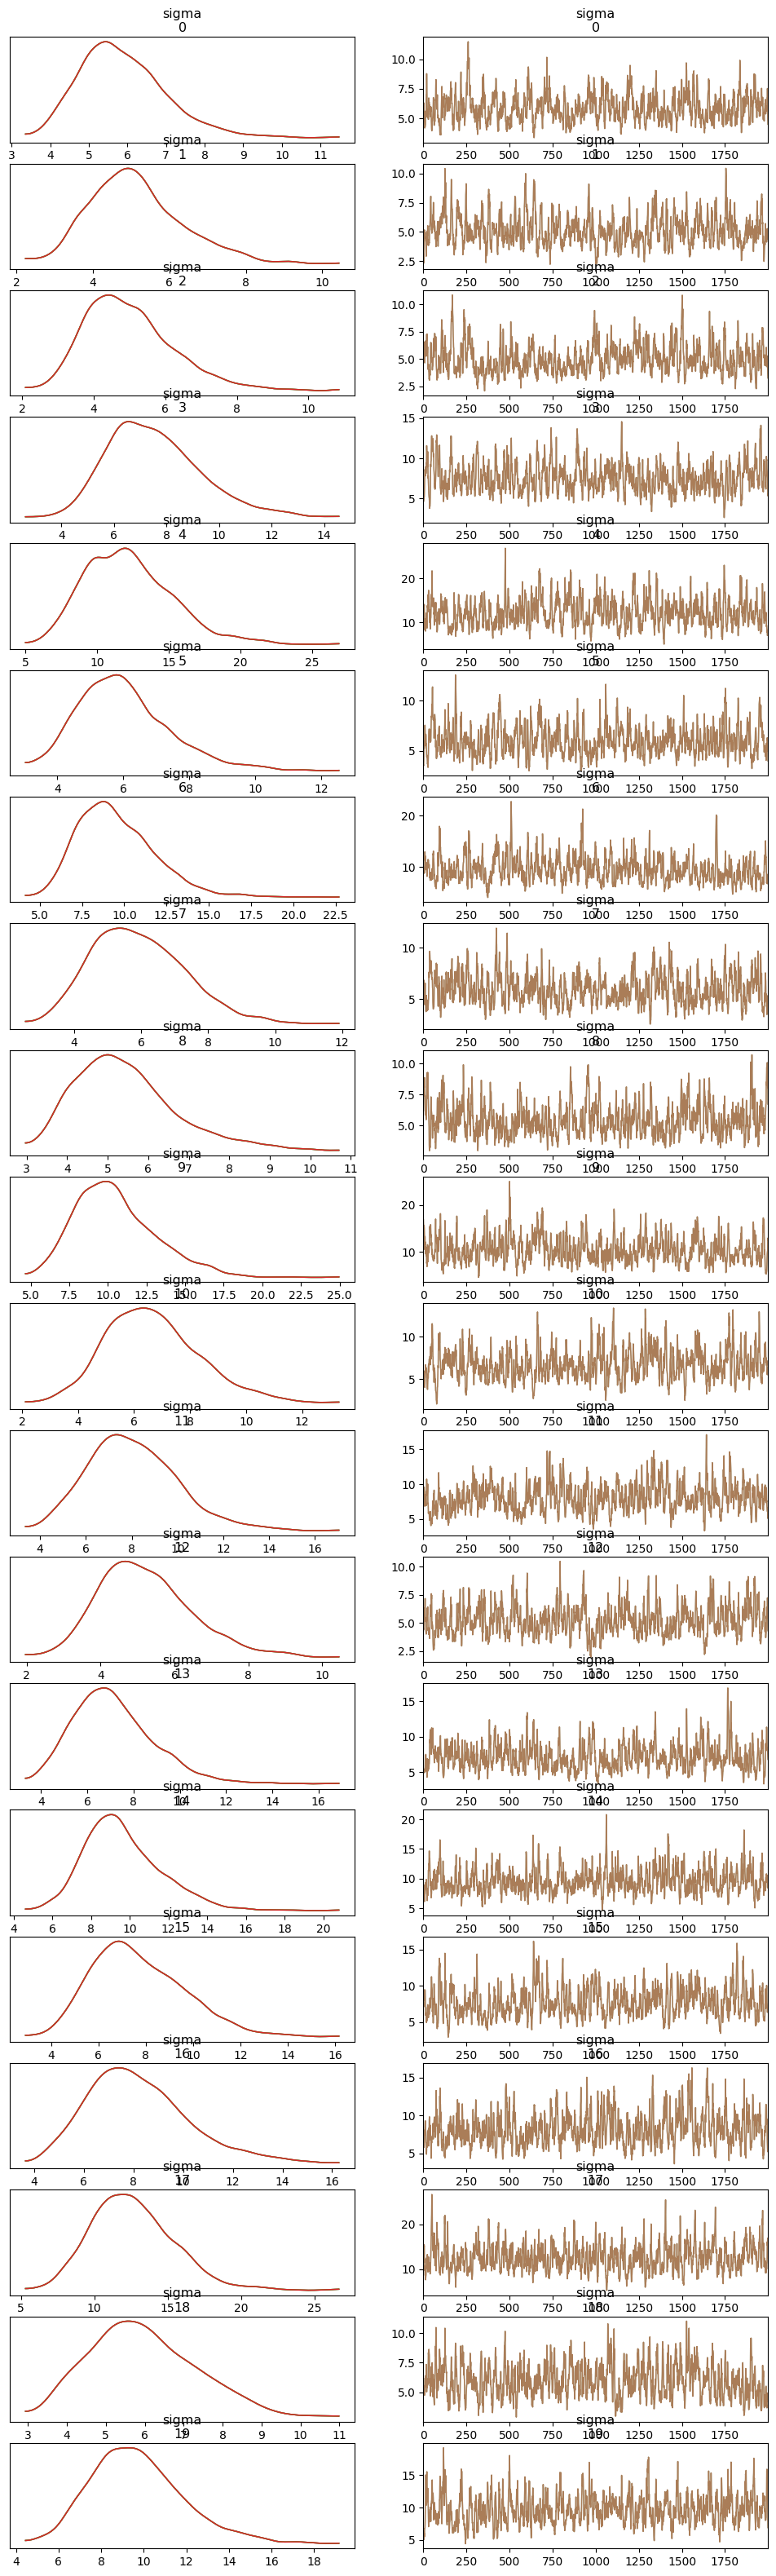

In [34]:
az.plot_trace(idata, var_names=["sigma"], compact=False)

In [41]:
single_play_raw = X_test.iloc[[0]]
actual_result = y_test.iloc[[0]].values[0]
single_play_processed = preprocessor.transform(single_play_raw)
single_play_input = single_play_processed.values if hasattr(single_play_processed, "values") else single_play_processed

In [44]:
with football_bart:
    pm.set_data({"X_data": single_play_input, "Y_data": np.zeros(len([0])).astype('int32')})
    post_pred = pm.sample_posterior_predictive(idata, var_names=['mu', 'sigma', 'y_obs'], predictions=True, random_seed=42,)

mu_samples = post_pred.predictions['mu'].values.flatten()
y_samples = post_pred.predictions['y_obs'].values.flatten()
sigma_samples = post_pred.predictions['sigma'].values.flatten()

Sampling: [mu, sigma_log, y_obs]


Output()

ValueError: Not enough dimensions on input.
Apply node that caused the error: Exp(sigma_log)
Toposort index: 1
Inputs types: [TensorType(float64, shape=(None,))]
Inputs shapes: [()]
Inputs strides: [()]
Inputs values: [array(2.35284699)]
Outputs clients: [[output[1](sigma), normal_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x151929D20>), MakeVector{dtype='int64'}.0, mu, sigma)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 663, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
    result = self._run_cell(
  File "/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
    result = runner(coro)
  File "/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/6l/fh4ck8px62x4x7vp3j9kjr6h0000gn/T/ipykernel_7336/3099431770.py", line 8, in <module>
    sigma = pm.Deterministic('sigma', pm.math.exp(sigma_log))

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
plt.figure